# Introduction to Python  

## Natural Language Processing - Exploratory Data Analysis (EDA)

In [1]:
!pip install -U -q pip nltk gensim wordcloud textract textstat textblob spacy pyldavis 
!pip install -U -q goose3 numpy openpyxl python-levenshtein openpyxl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.6.2 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.1 which is incompatible.
imageio 2.16.1 requires pillow>=8.3.2, but you have pillow 8.2.0 which is incompatible.


In [2]:
import os
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import requests
from bs4 import BeautifulSoup
import networkx as nx
import gensim

import nltk
from wordcloud import WordCloud
import textract
from goose3 import Goose
import textblob
from textblob import TextBlob
from textblob import Word

import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import textstat

from IPython.core.display import Image
%matplotlib inline

/home/renato/Documents/env_default/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/renato/Documents/env_default/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
2022-08-03 23:15:41.835395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 23:15:41

## I - Reading, formatting, visualizing and converting text from files 

Specifying the path to the files

In [3]:
datapath = "../../Data/"
outputs = "../../Data/"
corpuspath = os.path.join(datapath, 'Texts')

Examining files and folders programatically

In [4]:
onlydirs = [f for f in os.listdir(corpuspath) if os.path.isdir(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs

['french-tragedy-split',
 'french-tragedies-and-comedies',
 'french-tragedy',
 'british-fiction-corpus',
 'doccluster',
 'french-tragedies-and-comedies-split',
 'austen-brontë',
 'french-plays',
 'hugo-les-misérables-split',
 'outputs',
 'hugo-les-misérables-original',
 'austen-brontë-split',
 'Gutenberg',
 'stopwords',
 'hugo-les-misérables']

In [5]:
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlyfiles.sort()
onlyfiles

['ARTIGOS-RBE-COM-RESUMO.xlsx',
 'AldousHuxley_bravenewworld.pdf',
 'BNCC_EI_EF_110518_versaofinal_site.pdf',
 'MarcelProust_EmBuscadoTempoPerdido.pdf',
 'Possibly_Misclassified_Cables_Review.xlsx',
 'RobertFrost_Poetry.pdf',
 'abcnews-date-text.csv']

In [6]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- ARTIGOS-RBE-COM-RESUMO.xlsx
2 -- AldousHuxley_bravenewworld.pdf
3 -- BNCC_EI_EF_110518_versaofinal_site.pdf
4 -- MarcelProust_EmBuscadoTempoPerdido.pdf
5 -- Possibly_Misclassified_Cables_Review.xlsx
6 -- RobertFrost_Poetry.pdf
7 -- abcnews-date-text.csv


### 1. First task: analyzing a text field on a Dataframe

In [7]:
df = pd.read_excel(os.path.join(corpuspath, 'Possibly_Misclassified_Cables_Review.xlsx'))
df.head()

,id,link to orig. doc,Prob_Classified,Prob_Unclassified,Odds,date,origclass,subject
0,1975BANGKO06331,NaN,0.499997,0.500003,0.999987,1975-04-14,CONFIDENTIAL,gkr pl 480 rice in pipeline
1,1976MOSCOW15759,NaN,0.499995,0.500005,0.999980,1976-10-06,CONFIDENTIAL,oecd east-west initiative suggested addition
2,1974BOGOTA01772,NaN,0.499951,0.500049,0.999804,1974-02-28,CONFIDENTIAL,dea special agent positions
3,1975STATE034056,NaN,0.499901,0.500099,0.999605,1975-02-14,CONFIDENTIAL,homeporting destroyer tender in naples
4,1973STATE241960,NaN,0.499896,0.500104,0.999585,1973-12-11,CONFIDENTIAL,president ceausescu visit


In [8]:
df.columns

Index(['id', 'link to orig. doc', 'Prob_Classified', 'Prob_Unclassified',
       'Odds', 'date', 'origclass', 'subject'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16927 entries, 0 to 16926
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 16927 non-null  object        
 1   link to orig. doc  0 non-null      float64       
 2   Prob_Classified    16927 non-null  float64       
 3   Prob_Unclassified  16927 non-null  float64       
 4   Odds               16927 non-null  float64       
 5   date               16927 non-null  datetime64[ns]
 6   origclass          16927 non-null  object        
 7   subject            16920 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 1.0+ MB


#### Dropping the rows which are empty

In [10]:
df.dropna(axis='rows', subset=["subject"], inplace=True)

#### Adding a space at the end of each text and concatenating the texts

In [11]:
df['subject'] += " "
#df['subject'] = df['subject'] + " "

In [12]:
texts = df['subject'].sum()
texts[0:1000]

'gkr pl 480 rice in pipeline oecd east-west initiative suggested addition dea special agent positions homeporting destroyer tender in naples president ceausescu visit opec price decision letter from president carter to president eanes press guidance for npw visit orit boycott pinochet to address labor rally visit of belgian foreign minister to rwanda penney throws in towel srv participation in 20th session escap committee on trade changes in honduran economic leadership vietnamese refugees in thailand tarapur us-ussr housing agreement pre-departure briefing for u.s executive secretary 10.00 civair klm frequencies nkomo-callaghan meeting british hicom informs us that nkomo will depart lusaka night of july 26 for london will meet owens-illinois case annual congressional report on security assistance planned study in u.s by large group of libyans sponsored by libyan atomic energy commission demirel comments on cyprus los resumed seventh session the continental shelf international steel ag

#### Loading NLTK library and some corpora from NLTK

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /home/renato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /home/renato/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [14]:
stop_pt = nltk.corpus.stopwords.words('portuguese')
stop_en = nltk.corpus.stopwords.words('english')
stop_de = nltk.corpus.stopwords.words('german')
stop_en.extend(['-','', '”'])

#### Examining some stopwords

In [15]:
stop_en[0:15]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours']

#### Examining all punctuation, from string package

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Transforming the string in a list of words to perform cleaning

In [17]:
list_words = texts.split()

#### Converting all words to lowercase

In [18]:
list_words = [l.strip().lower() for l in list_words]

#### Eliminating trailing punctuactions from each word on the list

In [19]:
list_words = [l.strip(string.punctuation) for l in list_words]

#### Eliminating the stopwords using the NLTK stopwords corpus (English)

In [20]:
list_words = [l for l in list_words if l not in stop_en]

#### Using the [Counter](https://docs.python.org/3/library/collections.html) from Collections

In [21]:
from collections import Counter

freqdist = Counter(list_words)

In [22]:
freqdist.most_common(20)

[('visit', 1017),
 ('meeting', 791),
 ('us', 622),
 ('press', 581),
 ('request', 577),
 ('conference', 526),
 ('u.s', 486),
 ('minister', 482),
 ('president', 470),
 ('secretary', 446),
 ('foreign', 439),
 ('committee', 436),
 ('agreement', 395),
 ('ambassador', 364),
 ('report', 355),
 ('assistance', 334),
 ('new', 316),
 ('program', 305),
 ('group', 278),
 ('statement', 262)]

#### Creating wordcloud with [Wordcloud](https://github.com/amueller/word_cloud) library

In [23]:
from wordcloud import WordCloud

cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

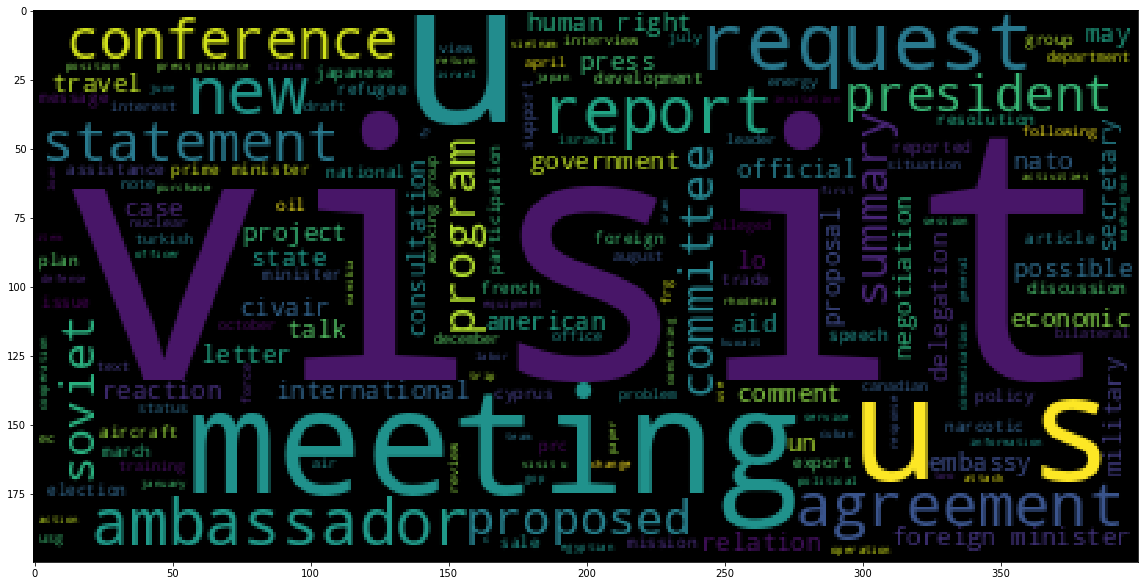

In [24]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

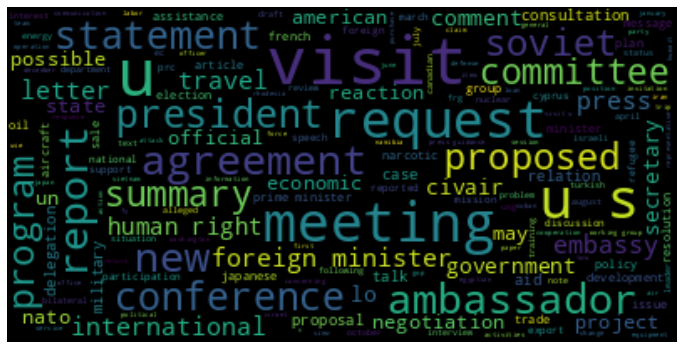

In [25]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(cleaned)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
# The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()

### 2. Second task: Reading and converting text from PDF file

In [27]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i, '--' ,w)

Files in the folder:
0 -- ARTIGOS-RBE-COM-RESUMO.xlsx
1 -- AldousHuxley_bravenewworld.pdf
2 -- BNCC_EI_EF_110518_versaofinal_site.pdf
3 -- MarcelProust_EmBuscadoTempoPerdido.pdf
4 -- Possibly_Misclassified_Cables_Review.xlsx
5 -- RobertFrost_Poetry.pdf
6 -- abcnews-date-text.csv


In [28]:
text = textract.process(os.path.join(corpuspath,onlyfiles[2])).decode('utf-8')

In [29]:
text[0:100]

'EDUCAÇÃO É A BASE\n\n\x0c\x0cEDUCAÇÃO É A BASE\n\n\x0cMINISTÉRIO DA EDUCAÇÃO\nMINISTRO DA EDUCAÇÃO\nRossieli Soares'

In [30]:
print(text[0:100])

EDUCAÇÃO É A BASE

EDUCAÇÃO É A BASE

MINISTÉRIO DA EDUCAÇÃO
MINISTRO DA EDUCAÇÃO
Rossieli Soares


In [31]:
print(len(text))

1104878


#### Cleaning and homogenizing texts:

In [32]:
cleaned_text = text.lower()
cleaned_text = re.sub(' +',' ', cleaned_text)              #Remove multiple spaces
cleaned_text = re.sub(r'\n\s*\n', '\n', cleaned_text)      #Remove multiple newlines

In [33]:
print(len(cleaned_text))

1100659


In [34]:
print(cleaned_text[0:200])

educação é a base
educação é a base
ministério da educação
ministro da educação
rossieli soares da silva
secretaria executiva
henrique sartori de almeida prado
secretaria de educação básica
katia c


In [35]:
list_words = cleaned_text.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation + '“”’“”–') for l in list_words]
list_words = [l for l in list_words if l not in stop_pt]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('', 922),
 ('diferentes', 859),
 ('ensino', 842),
 ('textos', 539),
 ('práticas', 534),
 ('fundamental', 516),
 ('base', 450),
 ('educação', 441),
 ('produção', 426),
 ('habilidades', 422),
 ('língua', 409),
 ('conhecimento', 404),
 ('nacional', 384),
 ('etc', 383),
 ('sobre', 381),
 ('vida', 362),
 ('identificar', 348),
 ('curricular', 345),
 ('objetos', 334),
 ('linguagens', 329)]

#### Finding ocurrences of a word:

In [36]:
word = 'direito'
pos = 0 
positions = []

while pos != -1:
    position = cleaned_text.find(word,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print(f'The word is found {len(positions)} times in the following positions:')
print(positions)

The word is found 149 times in the following positions:
[2084, 11529, 14085, 14973, 15042, 15072, 15163, 15226, 17850, 18416, 18932, 19030, 22903, 23374, 23672, 31910, 37456, 41655, 42014, 44779, 45122, 45534, 51892, 52552, 53509, 53698, 53780, 70936, 73506, 74697, 75520, 79202, 79488, 105056, 119174, 125041, 131984, 137189, 139223, 139325, 139985, 153196, 176474, 176609, 176718, 176729, 176760, 180313, 208531, 233268, 254112, 254286, 254316, 254392, 274274, 274509, 274763, 274956, 275029, 280246, 314228, 315507, 315863, 317394, 335657, 337929, 338459, 338546, 338880, 339005, 407791, 410566, 447070, 628931, 635047, 635273, 635639, 637015, 638287, 675723, 687334, 708453, 719896, 732781, 732858, 740077, 759154, 760507, 761496, 761542, 761655, 763164, 763609, 770077, 770164, 772881, 774308, 782290, 789769, 790678, 790720, 793471, 793631, 796910, 805081, 805291, 835197, 844034, 848400, 852141, 860327, 860760, 864922, 867322, 867682, 868828, 869661, 873700, 890696, 892126, 892646, 892691, 8

#### Understanding contexts in which words occur:

In [37]:
# Pure Python
#window = 18
#for position in positions[0:20]:
#    print(cleaned_text[position - window:position + window + len(word)].strip())

In [38]:
# Using NLTK

tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_text)
tokens = [token for token in tokens if token not in stop_pt]
nltk_text = nltk.Text(tokens)

nltk_text.concordance(word.lower(), width=120, lines=20)

Displaying 20 of 29 matches:
ituição federal 19885 , artigo 205 , reconhece educação direito fundamental compartilhado estado , família sociedade de
ilhado estado , família sociedade determinar educação , direito todos dever estado família , promovida incentivada cola
tunidades ingresso permanência escola educação básica , direito aprender concretiza . brasil , longo história , natural
cional comum curricular entretanto , embora reconhecida direito todas crianças dever estado , educação infantil passa o
rocínio unesco . disponível : < http :// - ipol . org / direito - linguistic >. acesso : 6 dez . 2017 . 32 mec , meio s
ronteira >. acesso : 6 dez . 2017 . povos indígenas têm direito constitucional desenvolver territórios projetos educaci
mpo atuação vida pública ), exercício desses direitos – direito literatura arte , direito informação conhecimentos disp
, exercício desses direitos – direito literatura arte , direito informação conhecimentos disponíveis . cada campo atuaç
ireitos hum

#### Words that occur in similar contexts than the query expression:

In [39]:
nltk_text.similar('direito')

ensino limites


#### [Collocations](http://en.wikipedia.org/wiki/Collocation) are expressions of multiple words which commonly co-occur.  
Ref: [NLTK](http://www.nltk.org/howto/collocations.html)  

In [40]:
nltk_text.collocation_list(num=20, window_size=20)

[('ensino', 'fundamental'),
 ('comum', 'curricular'),
 ('nacional', 'comum'),
 ('nacional', 'curricular'),
 ('base', 'comum'),
 ('base', 'curricular'),
 ('competências', 'específicas'),
 ('base', 'nacional'),
 ('língua', 'inglesa'),
 ('ensino', 'médio'),
 ('educação', 'básica'),
 ('unidades', 'temáticas'),
 ('língua', 'portuguesa'),
 ('esportes', 'esportes'),
 ('educação', 'educação'),
 ('ciências', 'humanas'),
 ('maria', 'maria'),
 ('objetos', 'conhecimento'),
 ('resolver', 'problemas'),
 ('consed', 'consed')]

#### Finding bigrams using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [41]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

malhas quadriculadas
dupla entrada
dirigente municipal
planilhas eletrônicas
faixa etária
itinerários formativos
sala aula
relacionam agrupamento
tendência central
ficha técnica
obrigatório desenho
estados unidos
tomados modelo
modelo obrigatório
23 mar
cumpre destacar
expressam arranjo
reta numérica
dispositivos aplicativos
adição subtração
agrupamentos propostos
composicional estilo
seres vivos
dezembro 1996
plano cartesiano
numeração decimal
discurso direto
muitas vezes
matriz indígena
unidos américa


### Finding bigrams using raw frequency

In [42]:
for a, b in (finder2.above_score(bigram_measures.raw_freq, 20.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

ensino fundamental
base nacional
nacional comum
comum curricular
ensino médio
objetos conhecimento
língua portuguesa
unidades temáticas
língua inglesa
fundamental habilidades
educação básica
fundamental –
– anos
ciências humanas
competências específicas
linguagens –
produção textos
práticas linguagem
etc .),
– língua
portuguesa ensino
práticas corporais
anos iniciais
ciências natureza
educação infantil
temáticas objetos
etc .)
etc .).
resolver elaborar
elaborar problemas
consed ),
dentre outros
anos finais
tecnologias digitais
efeitos sentido
http ://
curricular língua
direitos humanos
educação física
análise linguística
situação comunicativa
campos atuação
diferentes linguagens
vida cotidiana
tendo vista
considerando situação
competência específica
lei nº
áreas conhecimento
ano unidades
ensino religioso
portuguesa –
diário oficial
linguagem objetos
linguagens tecnologias
oficial união
9º ano
5º ano
conhecimento habilidades
números naturais
comunicativa tema
área ciências
aprendizagem 

### Finding Trigrams using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [43]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

ghisleine trigo silveira
adição parcelas iguais
tomados modelo obrigatório
modelo obrigatório desenho
20 dezembro 1996
tabelas dupla entrada
cumpre destacar critérios
concordância nominal verbal
matriz indígena africana
estados unidos américa
expressam arranjo possível
obrigatório desenho currículos
medidas tendência central
ênfases adicionadas ).
estabelece diretrizes bases
relacionam agrupamento desses
rossieli soares silva
formatação diagramação específica
sistema monetário brasileiro
quais relacionam agrupamento
escola acolhe juventudes
colaboração colegas ajuda
diário oficial união
http :// www
sistema numeração decimal
devem tomados modelo
representação decimal finita
acordo convenções gênero
http :// portal
propostos devem tomados


### Finding trigrams using raw frequency

In [44]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq, 20.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

base nacional comum
nacional comum curricular
ensino fundamental habilidades
ensino fundamental –
fundamental – anos
língua portuguesa ensino
temáticas objetos conhecimento
unidades temáticas objetos
– língua portuguesa
linguagens – língua
resolver elaborar problemas
portuguesa ensino fundamental
– anos iniciais
comum curricular língua
considerando situação comunicativa
– anos finais
ano unidades temáticas
língua portuguesa –
curricular língua portuguesa
diário oficial união
linguagem objetos conhecimento
práticas linguagem objetos
objetos conhecimento habilidades
situação comunicativa tema
ciências humanas –
matemática ensino fundamental
tecnologias ensino médio
gerais educação básica
objetos conhecimento campo
competências gerais educação
ciências humanas sociais
conselho nacional educação
humanas sociais aplicadas
outros gêneros campo
dentre outros gêneros
diretrizes curriculares nacionais
http :// portal
ciências natureza tecnologias
história ensino fundamental
campo vida cotidiana

### Finding n-grams using raw frequency

In [45]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
xgrams_counter.most_common(20)

[(('base', 'nacional', 'comum', 'curricular'), 292),
 (('ensino', 'fundamental', '–', 'anos'), 108),
 (('ensino', 'fundamental', 'habilidades', '('), 89),
 (('unidades', 'temáticas', 'objetos', 'conhecimento'), 78),
 (('–', 'língua', 'portuguesa', 'ensino'), 77),
 (('língua', 'portuguesa', 'ensino', 'fundamental'), 69),
 ((')', 'resolver', 'elaborar', 'problemas'), 65),
 (('linguagens', '–', 'língua', 'portuguesa'), 63),
 (('disponível', ':', '<', 'http'), 59),
 ((':', '<', 'http', '://'), 59),
 (('.', 'disponível', ':', '<'), 58),
 (('fundamental', '–', 'anos', 'iniciais'), 57),
 (('nacional', 'comum', 'curricular', 'língua'), 55),
 (('.', 'gov', '.', 'br'), 53),
 (('gov', '.', 'br', '/'), 53),
 (('fundamental', '–', 'anos', 'finais'), 51),
 (('ano', 'unidades', 'temáticas', 'objetos'), 49),
 (('análise', 'linguística', '/', 'semiótica'), 48),
 (('diário', 'oficial', 'união', ','), 47),
 (('oficial', 'união', ',', 'brasília'), 47)]

#### Creating a dispersion plot of words in the document

/home/renato/Documents/env_default/lib/python3.8/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded (please install Tkinter library).")


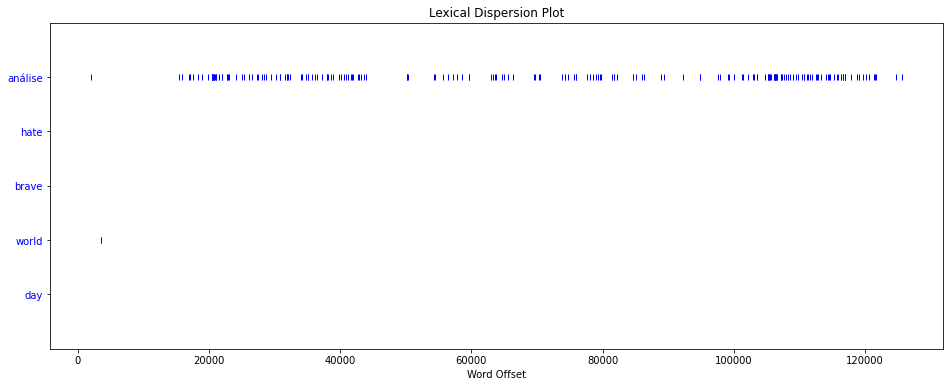

In [46]:
dispersion_words = ['análise', 'hate', 'brave','world', 'day']
plt.figure(figsize=(16,6))
nltk_text.dispersion_plot(dispersion_words)

#### Different ways to visualize frequent words:

In [47]:
freqdist.most_common(100)

[('', 922),
 ('diferentes', 859),
 ('ensino', 842),
 ('textos', 539),
 ('práticas', 534),
 ('fundamental', 516),
 ('base', 450),
 ('educação', 441),
 ('produção', 426),
 ('habilidades', 422),
 ('língua', 409),
 ('conhecimento', 404),
 ('nacional', 384),
 ('etc', 383),
 ('sobre', 381),
 ('vida', 362),
 ('identificar', 348),
 ('curricular', 345),
 ('objetos', 334),
 ('linguagens', 329),
 ('outros', 329),
 ('comum', 323),
 ('forma', 323),
 ('sociais', 309),
 ('analisar', 305),
 ('anos', 296),
 ('formas', 287),
 ('mundo', 283),
 ('campo', 283),
 ('ano', 274),
 ('relações', 274),
 ('meio', 273),
 ('uso', 272),
 ('desenvolvimento', 268),
 ('leitura', 253),
 ('gêneros', 253),
 ('estudantes', 252),
 ('texto', 240),
 ('conhecimentos', 238),
 ('médio', 237),
 ('problemas', 236),
 ('processos', 226),
 ('outras', 225),
 ('social', 223),
 ('ciências', 222),
 ('natureza', 221),
 ('tecnologias', 219),
 ('•', 215),
 ('compreensão', 207),
 ('linguagem', 201),
 ('culturais', 200),
 ('relação', 199),
 ('

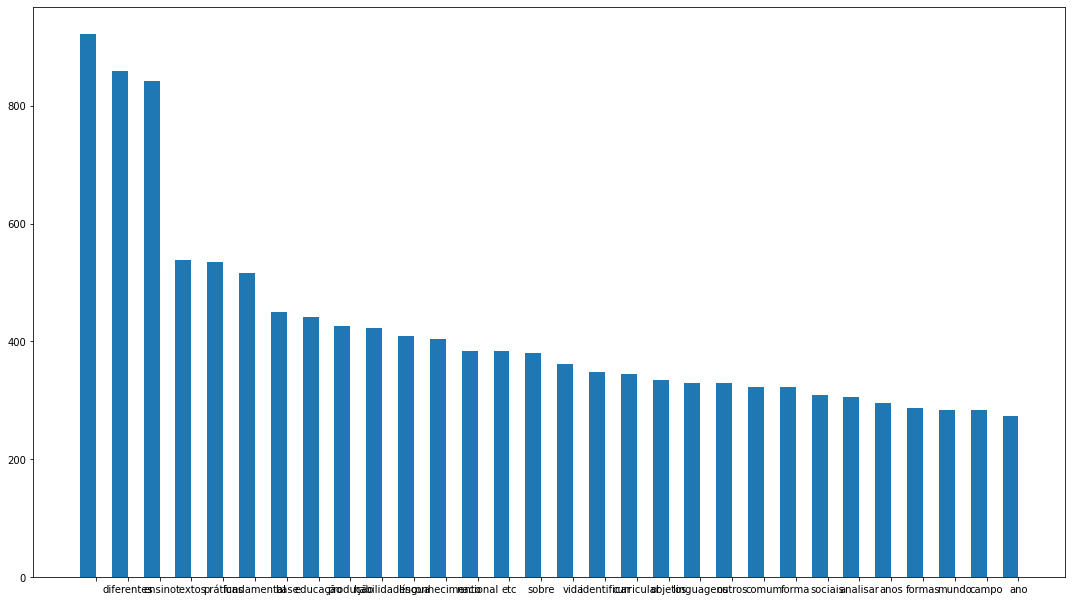

In [48]:
labels, values = zip(*freqdist.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

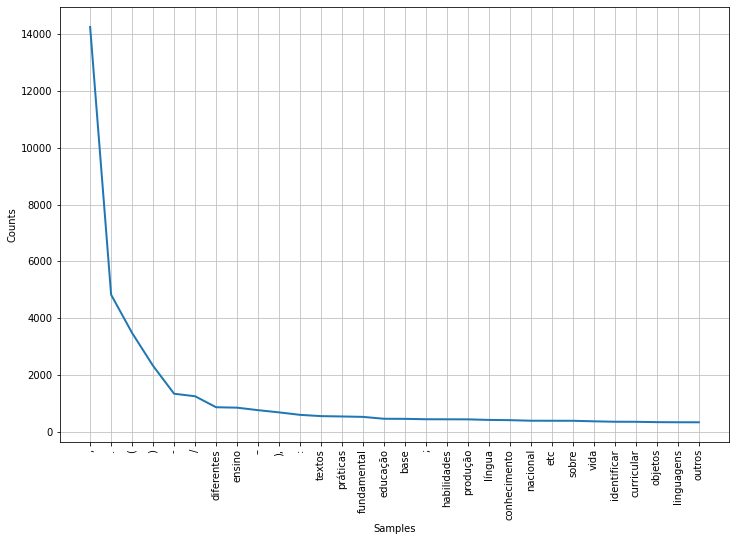

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [49]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

#### Cumulative distribution of frequencies:

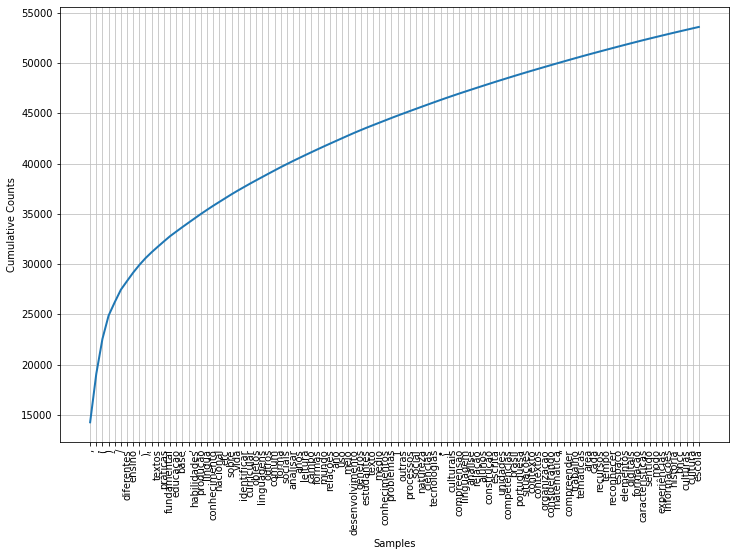

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(100, cumulative = True)

### 3. Third task: Extracting text from html pages using [Goose](https://github.com/goose3/goose3)

In [51]:
from goose3 import Goose

url = 'https://edition.cnn.com/2022/08/03/asia/china-reaction-pelosi-taiwan-intl-hnk-mic/index.html'

g = Goose()
#g = Goose(Goose({'use_meta_language': False, 'target_language':'en', 'parser_class':'lxml'}))

article = g.extract(url=url)

#### Extracting links

In [52]:
[l for l in article.links if l.startswith('http')]

['https://www.cnn.com/2022/08/03/economy/china-suspends-imports-taiwan-products-intl-hnk/index.html']

#### Extracting title

In [53]:
article.title

'Analysis: Pelosi angers China but Taiwan, not the US, may pay the higher price'

#### Extracting header

In [54]:
article.meta_description

'When US House Speaker Nancy Pelosi touched down in Taiwan on Tuesday night, China was ready with its response.'

#### Extracting cleaned text

In [55]:
article.cleaned_text[:]

'A version of this story appeared in CNN\'s Meanwhile in China newsletter, a three-times-a-week update exploring what you need to know about the country\'s rise and how it impacts the world. Sign up here.\n\n(CNN) When US House Speaker Nancy Pelosi touched down in Taiwan on Tuesday night, China was ready with its response.\n\nIn quick succession, a slew of government and political bodies fired off statements condemning the visit and warning of its "severe impact" on US-China relations, while China\'s military said it would immediately launch "air and sea exercises" and released a plan for drills surrounding the island in coming days.\n\nPelosi\'s visit -- the first by a top-ranked US lawmaker in 25 years and part of a larger Asia tour -- was seen by Beijing as a "major political provocation" and a challenge to China\'s sovereignty. China\'s ruling Communist Party claims the self-governed democracy of Taiwan as its own, despite never having controlled it.\n\nDespite Beijing\'s objection

In [56]:
article.top_image

## II - Translation, Part of Speech, advanced NLP functions

#### 3.1 Using [Textblob](http://textblob.readthedocs.io/en/dev/) ([Github](https://github.com/sloria/TextBlob))

[Another article](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/)

In [57]:
from textblob import TextBlob
from textblob import Word

In [58]:
!python -m textblob.download_corpora

/home/renato/Documents/env_default/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package brown to /home/renato/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/renato/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloadin

In [59]:
text_en = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant.
'''

text_de = '''
Familie Müller plant ihren Urlaub. Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. Als Reiseziel wählt sie Mallorca aus. 
Familie Müller bucht einen Flug auf die Mittelmeerinsel. Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. Familie Müller badet gerne im Meer.
Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. Dort warten schon viele Urlauber. Alle wollen nach Mallorca fliegen. 
Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 
Die Taschen sind Handgepäck. Familie Müller nimmt sie mit in das Flugzeug. 
Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. Es ist nicht mehr 
viel Zeit bis zum Abflug. Familie Müller geht durch die Sicherheitskontrolle. 
Als alle das richtige Gate erreichen, setzen sie sich in den Wartebereich. 
Kurz darauf wird ihre Flugnummer aufgerufen und Familie Müller steigt mit vielen 
anderen Passagieren in das Flugzeug nach Mallorca. Beim Starten fühlt sich Herr Müller 
nicht wohl. Ihm wird ein wenig übel. Nach zwei Stunden landet das Flugzeug. 
Am Gepäckband warten alle Passagiere noch auf ihr fehlendes Gepäck. Danach 
kann endlich der Urlaub beginnen.
'''

In [60]:
blob_en = TextBlob(text_en)
blob_de = TextBlob(text_de)

In [61]:
for s in blob_en.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact. 

Sentence: Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant. 



In [62]:
for s in blob_de.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
Familie Müller plant ihren Urlaub. 

Sentence: Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. 

Sentence: Als Reiseziel wählt sie Mallorca aus. 

Sentence: Familie Müller bucht einen Flug auf die Mittelmeerinsel. 

Sentence: Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. 

Sentence: Familie Müller badet gerne im Meer. 

Sentence: Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. 

Sentence: Dort warten schon viele Urlauber. 

Sentence: Alle wollen nach Mallorca fliegen. 

Sentence: Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 

Sentence: Die Taschen sind Handgepäck. 

Sentence: Familie Müller nimmt sie mit in das Flugzeug. 

Sentence: Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. 

Sentence: Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. 

Sentence: Es ist nicht mehr 
viel Zeit bis zum Abflug. 

Sentence: 

In [63]:
blob_en.sentences[1].words

WordList(['Snide', 'comparisons', 'to', 'gelatin', 'be', 'damned', 'it', "'s", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequences', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorists', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

Functions applied to the Word object:  

In [64]:
w = Word('Platform')
w.pluralize()

'Platforms'

In [65]:
blob_en.sentences[1].words.singularize()

WordList(['Snide', 'comparison', 'to', 'gelatin', 'be', 'damned', 'it', "'", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequence', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorist', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

In [66]:
w = Word('running')
w.lemmatize("v") ## v here represents verb

'run'

POS tags  

In [67]:
blob_en.tags[0:10]

[('The', 'DT'),
 ('titular', 'JJ'),
 ('threat', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Blob', 'NNP'),
 ('has', 'VBZ'),
 ('always', 'RB'),
 ('struck', 'VBN'),
 ('me', 'PRP')]

In [68]:
blob_de.tags[0:10]

[('Familie', 'NNP'),
 ('Müller', 'NNP'),
 ('plant', 'NN'),
 ('ihren', 'NN'),
 ('Urlaub', 'NNP'),
 ('Sie', 'NNP'),
 ('geht', 'NN'),
 ('in', 'IN'),
 ('ein', 'JJ'),
 ('Reisebüro', 'NNP')]

Ngrams  

In [69]:
for ngram in blob_en.ngrams(2):
    print(ngram)

['The', 'titular']
['titular', 'threat']
['threat', 'of']
['of', 'The']
['The', 'Blob']
['Blob', 'has']
['has', 'always']
['always', 'struck']
['struck', 'me']
['me', 'as']
['as', 'the']
['the', 'ultimate']
['ultimate', 'movie']
['movie', 'monster']
['monster', 'an']
['an', 'insatiably']
['insatiably', 'hungry']
['hungry', 'amoeba-like']
['amoeba-like', 'mass']
['mass', 'able']
['able', 'to']
['to', 'penetrate']
['penetrate', 'virtually']
['virtually', 'any']
['any', 'safeguard']
['safeguard', 'capable']
['capable', 'of']
['of', 'as']
['as', 'a']
['a', 'doomed']
['doomed', 'doctor']
['doctor', 'chillingly']
['chillingly', 'describes']
['describes', 'it']
['it', 'assimilating']
['assimilating', 'flesh']
['flesh', 'on']
['on', 'contact']
['contact', 'Snide']
['Snide', 'comparisons']
['comparisons', 'to']
['to', 'gelatin']
['gelatin', 'be']
['be', 'damned']
['damned', 'it']
['it', "'s"]
["'s", 'a']
['a', 'concept']
['concept', 'with']
['with', 'the']
['the', 'most']
['most', 'devastating'

Noun Phrase Extraction

In [70]:
blob_en.noun_phrases

WordList(['titular threat', 'blob', 'ultimate movie monster', 'amoeba-like mass', 'snide', 'potential consequences', 'grey goo scenario', 'technological theorists', 'artificial intelligence run rampant'])

In [71]:
blob_de.noun_phrases

WordList(['familie müller', 'plant ihren', 'urlaub', 'sie', 'reisebüro', 'und lässt sich von einem', 'angestellten', 'als reiseziel', 'wählt sie', 'mallorca', 'familie müller', 'bucht einen', 'flug', 'mittelmeerinsel', 'sie', 'bucht außerdem zwei', 'zimmer', 'einem großen hotel direkt', 'strand', 'familie müller', 'badet gerne im', 'meer', 'am abflugtag', 'herr', 'frau müller', 'mit ihren beiden', 'kindern', 'taxi', 'flughafen', 'dort', 'warten schon viele', 'urlauber', 'alle', 'wollen nach', 'mallorca', 'familie müller', 'hat viel', 'gepäck', 'drei große', 'koffer', 'und zwei', 'taschen', 'die taschen', 'handgepäck', 'familie müller', 'nimmt sie mit', 'flugzeug', 'am flugschalter', 'familie', 'ein und erhält ihre', 'bordkarten', 'die angestellte', 'flugschalter', 'herrn müller', 'weg', 'flugsteig', 'es', 'ist nicht mehr viel', 'zeit', 'bis zum', 'abflug', 'familie müller', 'geht durch', 'sicherheitskontrolle', 'als', 'alle das richtige gate erreichen', 'setzen sie sich', 'wartebereich

Sentiment Analysis  

In [72]:
for sentence in blob_en.sentences:
    print(sentence.sentiment.polarity)

0.06000000000000001
-0.34166666666666673


Spellcheck

In [73]:
sentence = TextBlob('The Austrien Centre for Digital Humanities and Cultural Heritaige from the Austrian Academy of Sciences')
sentence.correct()

TextBlob("The Austrian Centre for Digital Humanities and Cultural Heritage from the Austrian Academy of Sciences")

In [74]:
blob_en.words[5].spellcheck()

[('Low', 0.19878603945371776),
 ('Blow', 0.10925644916540213),
 ('Club', 0.10773899848254932),
 ('Clot', 0.1062215477996965),
 ('Slow', 0.09863429438543247),
 ('Flow', 0.07283763277693475),
 ('Lot', 0.05311077389984825),
 ('Mob', 0.03945371775417299),
 ('Glow', 0.03338391502276176),
 ('Log', 0.030349013657056147),
 ('Sob', 0.028831562974203338),
 ('Globe', 0.024279210925644917),
 ('Plot', 0.018209408194233688),
 ('Job', 0.01669195751138088),
 ('Plow', 0.013657056145675266),
 ('Rob', 0.007587253414264037),
 ('Slab', 0.006069802731411229),
 ('Los', 0.004552352048558422),
 ('Bob', 0.004552352048558422),
 ('Knob', 0.0030349013657056147),
 ('Flop', 0.0030349013657056147),
 ('Flog', 0.0030349013657056147),
 ('Blot', 0.0030349013657056147),
 ('Slot', 0.0015174506828528073),
 ('Slop', 0.0015174506828528073),
 ('Loi', 0.0015174506828528073),
 ('Lo', 0.0015174506828528073),
 ('Lb', 0.0015174506828528073),
 ('Lab', 0.0015174506828528073),
 ('Cob', 0.0015174506828528073),
 ('Bloc', 0.0015174506828

Text classification

In [75]:
training = [
('Tom Holland is a terrible spiderman.','neg'),
('a terrible Javert (Russell Crowe) ruined Les Miserables for me...','neg'),
('The Dark Knight Rises is the greatest superhero movie ever!','pos'),
('Fantastic Four should have never been made.','neg'),
('Wes Anderson is my favorite director!','pos'),
('Captain America 2 is pretty awesome.','pos'),
("Let's pretend \"Batman and Robin\" never happened..",'neg'),
]

testing = [
('Superman was never an interesting character.','neg'),
('Fantastic Mr Fox is an awesome film!','pos'),
('Dragonball Evolution is simply terrible!!','neg')
]

In [76]:
from textblob import classifiers
nb_classifier = classifiers.NaiveBayesClassifier(training)
dt_classifier = classifiers.DecisionTreeClassifier(training)

In [77]:
print (nb_classifier.accuracy(testing))

1.0


In [78]:
print (dt_classifier.accuracy(testing))

0.6666666666666666


In [79]:
nb_classifier.show_informative_features(4)

Most Informative Features
            contains(is) = True              pos : neg    =      2.9 : 1.0
             contains(a) = False             pos : neg    =      1.8 : 1.0
         contains(never) = False             pos : neg    =      1.8 : 1.0
      contains(terrible) = False             pos : neg    =      1.8 : 1.0


In [80]:
blob = TextBlob('the weather is terrible!', classifier=dt_classifier)
print (blob.classify())

pos


#### 3.2 Using [Spacy](https://spacy.io/)

[Doc 1](https://spacy.io/usage/spacy-101#lightning-tour), [Doc 2](https://github.com/explosion/spacy-notebooks), [Doc 3](https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/advanced_text_analysis.ipynb)

Downloading the language models from Spacy

In [81]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm
#!python -m spacy download pt_core_news_sm
#!python -m spacy download de_core_news_md

!python -m spacy validate

/home/renato/Documents/env_default/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
2022-08-03 23:16:08.785687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 23:16:08.785731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/renato/Documents/env_default/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of 

Load resources and process text

In [82]:
import spacy

In [83]:
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')
pt_nlp = spacy.load('pt_core_news_sm')

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
text_german = '''
Der du von dem Himmel bist,
Alles Leid und Schmerzen stillest,
Den, der doppelt elend ist,
Doppelt mit Erquickung füllest;
Ach, ich bin des Treibens müde!
Was soll all der Schmerz und Lust?
Süßer Friede,
Komm, ach komm in meine Brust!
'''

text_english = '''
somewhere i have never travelled, gladly beyond
any experience,your eyes have their silence:
in your most frail gesture are things which enclose me,
or which i cannot touch because they are too near.
Your slightest look easily will unclose me
though i have closed myself as fingers,
you open always petal by petal myself as Spring opens
(touching skilfully, mysteriously) her first rose.
Or if your wish be to close me,i and
my life will shut very beautifully,suddenly,
as when the heart of this flower imagines
the snow carefully everywhere descending;
nothing which we are to perceive in this world equals
the power of your intense fragility: whose texture
compels me with the colour of its countries,
rendering death and forever with each breathing.
I do not know what it is about you that closes
and opens; only something in me understands
the voice of your eyes is deeper than all roses)
nobody, not even the rain, has such small hands.

'''

text_portuguese = '''
Ora (direis) ouvir estrelas! Certo
Perdeste o senso!" E eu vos direi, no entanto,
Que, para ouvi-las, muita vez desperto
E abro as janelas, pálido de espanto...

E conversamos toda a noite, enquanto
A via-láctea, como um pálio aberto,
Cintila. E, ao vir do sol, saudoso e em pranto,
Inda as procuro pelo céu deserto.

Direis agora: "Tresloucado amigo!
Que conversas com elas? Que sentido
Tem o que dizem, quando estão contigo?"

E eu vos direi: "Amai para entendê-las!
Pois só quem ama pode ter ouvido
Capaz de ouvir e de entender estrelas. 
'''

In [ ]:
en_doc = en_nlp(text_english)
de_doc = de_nlp(text_german)
pt_doc = pt_nlp(text_portuguese)

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document:

In [ ]:
print(en_doc[0:7])

You can also iterate over the sentences. doc.sents is a generator object, so we can use next():

In [ ]:
en_Sents = list(en_doc.sents)
print(en_Sents)

For example, let's find the longest sentence(s):

In [ ]:
SentenceLengths = [len(sent) for sent in en_Sents]
[sent for sent in en_Sents if len(sent) == max(SentenceLengths)]

Exploring Words: each word has a huge number of properties:

In [ ]:
print(en_doc[2])
print(type(en_doc[2]))

In [ ]:
[prop for prop in dir(en_doc[2]) if not prop.startswith('_')]

Using just the indices (.i), we can make a lexical dispersion plot for the occurrences of that word in the novel. (This is just the SpaCy equivalent of the lexical dispersion plot from the NLTK)

In [ ]:
en_doc[2].i

In [ ]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram([word.i for word in haystack if word.text.lower() == needle], bins=50)[0])

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), en_doc) 
     for name in ['an', 'as', 'by']}
).plot(subplots=True)

Exploring [Named Entities](https://spacy.io/api/annotation)

Named entities can be accessed through doc.ents

In [ ]:
news_text = '''
Mexico City (CNN)At least 54 people were killed and more than 100 injured when a truck overturned in southern Mexico on Thursday, with most of the victims believed to be migrants from Central America, according to local authorities.
The incident happened in Mexico's Chiapas state, which borders Guatemala, when the truck carrying dozens of migrants crashed. Photos from the scene show the truck on its side next to a footbridge and bodies laid out on the road wrapped in body bags.
State Governor Rutilio Escandón tweeted that in addition to the deaths, 105 people were injured in the crash -- among them are 83 men and 22 and women.
'''

en_doc2 = en_nlp(news_text)

In [ ]:
set([w.label_ for w in en_doc2.ents])

In [ ]:
[ent for ent in en_doc2.ents if ent.label_ == 'LOC']

In [ ]:
[ent for ent in en_doc2.ents if ent.label_ == 'GPE']

Parts of Speech  

Each word already has a part of speech and a tag associated with it.

In [ ]:
tagDict = {w.pos: w.pos_ for w in en_doc2} 
tagDict

In [ ]:
en_docPOS = pd.Series(en_doc2.count_by(spacy.attrs.POS))/len(en_doc2)

df = pd.DataFrame([en_docPOS], index=['en'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

In [ ]:
en_docProns = [w for w in en_doc2 if w.pos_ == 'PRON']
Counter([w.text.strip() for w in en_docProns]).most_common(10)

In [ ]:
en_docSents = [sent for sent in en_doc2.sents if 'Mexico' in sent.text]
en_docSents

In [ ]:
for word in en_docSents[1]: 
    print(word, word.tag_, word.pos_)

Dependency Parsing  

Now let's analyze the structure of the sentence.  

This sentence has lots of properties:  

In [ ]:
[prop for prop in dir(en_docSents[1]) if not prop.startswith('_')]

To drill down into the sentence, we can start with the root:

In [ ]:
en_docSents[1].root

In [ ]:
list(en_docSents[1].root.children)

In [ ]:
for word in en_docSents[1]: 
    print(word, ': ', str(list(word.children)))

Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document.  
Let's see what the distribution is like:

In [ ]:
probabilities = [word.prob for word in en_doc] 
pd.Series(probabilities).hist()

Let's peek at some of the improbable words

In [ ]:
list(set([word.text.strip().lower() for word in en_doc if word.prob < -19]))[:20]

In [ ]:
Counter([word.text.strip().lower() 
         for word in en_doc 
         if word.prob < -19.5]).most_common(20)

In [ ]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.text.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [ ]:
docGrams = set(ngrams(en_doc, 3))

In [ ]:
for gram in docGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

### EDA text pipeline based in [this](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) and [this](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) articles  

#### Analyzing text statistics

Text statistics visualizations are simple but very insightful techniques. 

They include:

- word frequency analysis,
- sentence length analysis,
- average word length analysis

In [ ]:
news= pd.read_csv(os.path.join(datapath, 'Texts','abcnews-date-text.csv'),nrows=10000)
news.head(3)

#### First, let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

In [ ]:
news['headline_text'].str.len().hist()

#### Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each news headline.

In [ ]:
news['headline_text'].str.split().map(lambda x: len(x)).hist()

#### Up next, let’s check the average word length in each sentence.

In [ ]:
news['headline_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### Loading stopwords list

In [ ]:
#import nltk
#nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

#### Now, we’ll  create the corpus.

In [ ]:
corpus=[]
new = news['headline_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

#### Plot top stopwords

In [ ]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

#### We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples.

In [ ]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#### Ngram exploration  

Ngrams are simply contiguous sequences of n words.   

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  

In [ ]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

#### To build a representation of our vocabulary we will use Countvectorizer.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [ ]:
top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#### How about trigrams?

In [ ]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

#### Topic Modeling exploration with pyLDAvis

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus = []
    stem = nltk.stem.PorterStemmer()
    lem = nltk.stem.WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_news(news)

#### Now, let’s create the bag of words model using gensim

In [ ]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

#### Create the LDA model:

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2,  per_word_topics=True)
lda_model.show_topics()

#### What is the Dominant topic and its percentage contribution in each document

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model, bow_corpus, news['headline_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

#### Frequency Distribution of Word Counts in Documents

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(24,12), dpi=160)
plt.hist(doc_lens, color='navy') #, bins = 100)
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count',) # xlim=(0, 100),)
plt.tick_params(size=16)
#plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

#### By Topic

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, color=cols[i]) #, bins = 1000)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count') #xlim=(0, 1000),
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Word Clouds of Top N Keywords in Each Topic

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Counts of Topic Keywords

In [ ]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in news['headline_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Sentence Chart Colored by Topic

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 
                    0.5, 
                    "Doc " + str(i-1) + ": ", 
                    verticalalignment='center',
                    fontsize=16, 
                    color='black',
                    transform=ax.transAxes, 
                    fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, color = mycolors[topics],
                            transform = ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, 
                    '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model, bow_corpus)    

#### What are the most discussed topics in the documents?

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bow_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#### t-SNE Clustering Chart

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

#### Visualizes the results of LDA interactively

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

#### Wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

#### Sentiment analysis

In [ ]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score'] = news['headline_text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

#### Let’s dig a bit deeper by classifying the news as negative, positive and neutral based on the scores.

In [ ]:
def sentiment(x):
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))
plt.bar(news.polarity.value_counts().index, news.polarity.value_counts())

In [ ]:
news[news['polarity'] == 'pos']['headline_text'].head()

In [ ]:
news[news['polarity'] == 'neg']['headline_text'].head()

#### Vader Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index, polarity.value_counts())

#### Named Entity Recognition

In [ ]:
#!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

In [ ]:
from spacy import displacy

displacy.render(doc, style='ent')

In [ ]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = news['headline_text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

#### Now, we can visualize the entity frequencies: 

In [ ]:
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

#### We can also visualize the most common token per entity

In [ ]:
def ner(text, ent="GPE"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = news['headline_text'].apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x)

#### Most common names on News headlines

In [ ]:
per = news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x)

#### Exploration through Parts of Speach Tagging in python

In [ ]:
import nltk
sentence = "The greatest comeback stories in 2019"
tokens = nltk.tokenize.word_tokenize(sentence)
nltk.pos_tag(tokens)

In [ ]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

#### Now that we now what POS tagging is, let’s use it to explore our headlines dataset

In [ ]:
def pos(text):
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    pos = list(map(list,zip(*pos)))[1]
    return pos

tags = news['headline_text'].apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### We can dig deeper into this by investigating which singular noun occur most commonly in news headlines

In [ ]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    for word,tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj


words = news['headline_text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### Exploring through text complexity  

Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.  

In [ ]:
from textstat import flesch_reading_ease

news['headline_text'].apply(lambda x : flesch_reading_ease(x)).hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5  

In [ ]:
news['reading'] = news['headline_text'].apply(lambda x : flesch_reading_ease(x))
x = [i for i in range(len(news['reading'])) if news['reading'].iloc[i] < 5]
news.iloc[x]['headline_text'].head()